In [21]:
import ase
import numpy as np
import torch
torch.set_default_dtype(torch.float64)
from mlelec.data.dataset import QMDataset
from mlelec.utils.target_utils import get_targets
from mlelec.features.acdc import compute_features
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.pbc_utils import blocks_to_matrix
import matplotlib.pyplot as plt

In [2]:
frame = ase.Atoms("C6H6")
rc = 1.384
rh = 2.465
for i in range(6):
    frame.positions[i] = [np.cos(i*np.pi/3)*rc,np.sin(i*np.pi/3)*rc,0]
    frame.positions[i+6] = [np.cos(i*np.pi/3)*rh,np.sin(i*np.pi/3)*rh,0]

In [3]:
np.random.seed(321)
torch.random.manual_seed(321)
fock = np.random.uniform(size=(30,30))
fock = fock+fock.T
ref_eva = np.linalg.eigvalsh(fock)

In [4]:
device = 'cpu'
orbitals = {'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]}}
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3
cutoff = 6
LCUT = 3

In [5]:
dataset = QMDataset(frames = [frame], 
                   kmesh = [1,1,1], 
                   fix_p_orbital_order=True,
                   dimension = 0,
                   fock_realspace=[fock],
                   device = device, 
                   orbs = orbitals['benzene'], 
                   orbs_name = None
                   )

/home/pegolo/Software/mlelec/src/mlelec/data/dataset.py:912: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [6]:
target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)

In [7]:
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

In [8]:
hfeat = compute_features(dataset, hypers_atom, LCUT, hypers_pair = hypers_pair)

cpu pair features
cpu single center features
cpu single center features


In [11]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    return loss, pred, ridges, block_losses

In [12]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, 
                                  orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -1, 100),
                                                                        )
print(loss_ridge_bias)

tensor(534.4078)


In [13]:
ld = np.linspace(-0.1,0.1,31)
frames_displace = []
fockdummy = []
for i,d in enumerate(ld):
    fd = frame.copy()    
    cent = fd.positions.mean(axis=0)
    fd.positions -= cent
    fd.positions[[-5,-2]] *= 1+d
    fd.positions[[-6,-3]] *= 1-d
    fd.positions += cent
    frames_displace.append(fd)
    fockdummy.append(np.zeros_like(fock))
    
dataset_displaced = QMDataset(frames = frames_displace, 
                              kmesh = [1,1,1], 
                              fix_p_orbital_order=True,
                              dimension = 0,
                              fock_realspace=fockdummy,
                              device = device, 
                              orbs = orbitals['benzene'], 
                              orbs_name = None
                              )

/home/pegolo/Software/mlelec/src/mlelec/data/dataset.py:912: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [14]:
hfeat_d = compute_features(dataset_displaced, hypers_atom, LCUT, hypers_pair=hypers_pair)

cpu pair features
cpu single center features
cpu single center features


In [15]:
pred_disp = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_d)

/home/pegolo/Software/mlelec/src/mlelec/models/linear.py:868: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [18]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
fock_disp = [f[0,0,0].numpy() for f in fockd]

In [19]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

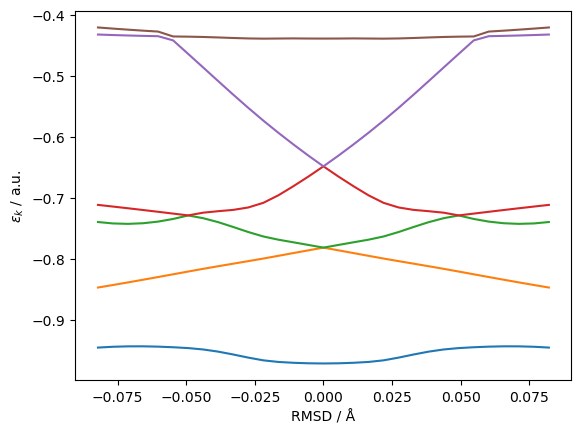

In [22]:
for k in range(0,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")
# plt.savefig("../figures/benzene-deformations.svg")